## Import Packages

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer

import joblib

import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

import newspaper
from newspaper import Article
from newspaper.article import ArticleException

from tqdm import tqdm

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

from newspaper import news_pool


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cameronbayer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## News Site Scraping

In [58]:
sites_df = {
    'link': [
        'https://www.foxnews.com/politics',
        'https://www.breitbart.com/politics/',
        'https://www.theamericanconservative.com/category/politics/',
        'https://www.oann.com/',
        'https://fortune.com/the-latest/',
        'https://www.forbes.com/?sh=4c70701d2254',
        'https://www.cbsnews.com/',
        'https://www.bbc.com/news',
        'https://www.cnn.com/politics',
        'https://www.politico.com/',
        'https://www.vox.com/',
        'https://www.msnbc.com/',
        'https://www.businessinsider.com/politics'
    ],
    'name': [
        'Fox News', 'Breitbart', 'The American Conservative', 'OANN',
        'Fortune', 'Forbes', 'CBS News', 'BBC News', 'CNN',
        'Politico', 'Vox', 'MSNBC', 'Business Insider'
    ],
    'clean_name': [
        'fox_news', 'breitbart', 'the_american_conservative', 'oann',
        'fortune', 'forbes', 'cbs_news', 'bbc_news', 'cnn',
        'politico', 'vox', 'msnbc', 'business_insider'
    ],
    'affiliation': [
        'Right', 'Right', 'Right', 'Right', 'Center', 
        'Center', 'Center', 'Center', 'Left', 
        'Left', 'Left', 'Left', 'Left'
    ]
}

sites = pd.DataFrame(sites_df)
sites

,link,name,clean_name,affiliation
0,https://www.foxnews.com/politics,Fox News,fox_news,Right
1,https://www.breitbart.com/politics/,Breitbart,breitbart,Right
2,https://www.theamericanconservative.com/catego...,The American Conservative,the_american_conservative,Right
3,https://www.oann.com/,OANN,oann,Right
4,https://fortune.com/the-latest/,Fortune,fortune,Center
5,https://www.forbes.com/?sh=4c70701d2254,Forbes,forbes,Center
6,https://www.cbsnews.com/,CBS News,cbs_news,Center
7,https://www.bbc.com/news,BBC News,bbc_news,Center
8,https://www.cnn.com/politics,CNN,cnn,Left
9,https://www.politico.com/,Politico,politico,Left


In [23]:
news_sources = []

for i, news in enumerate(sites['link']):
    news_sources.append(newspaper.build(news))

news_sources

In [41]:
news_sources[0].articles[20].url

'https://www.foxnews.com/media/cnn-legal-analyst-fires-back-carville-calls-criticism-trump-trial-downright-awful'

In [59]:
from newspaper import Config


USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'

config = Config()
config.browser_user_agent = USER_AGENT
config.request_timeout = 10

In [60]:
news_sources = []

for i, site in enumerate(tqdm(sites['link'], desc='Building sites')):
    try:
        paper = newspaper.build(site, config=config, memoize_articles=False)
        news_sources.append(paper)
    except Exception as e:
        print(f"Failed to build newspaper for site {site}: {e}")
        continue


news_pool.set(news_sources, threads_per_source=2) # (3*2) = 6 threads total
news_pool.join()



articles_data = []

for i, news_site in enumerate(tqdm(news_sources, desc=f'Processing articles', leave=False)):
    article = news_site.articles
    for link in article:
        try:
            link.parse()
            articles_data.append({'title': link.title, 'authors': link.authors, 'publish_date':link.publish_date, 'text': link.text, 'top_image':link.top_image, 'article': link.url, 'site': sites.loc[i, 'clean_name'], 'site_name': sites.loc[i, 'name'], 'bias': sites.loc[i, 'affiliation']})
        except ArticleException as e:
            print(f"ArticleException for {link.url}: {e}")
            continue
        except Exception as e:
            print(f"Unexpected exception for {link.url}: {e}")
            continue


all_news_articles = pd.DataFrame(articles_data)
all_news_articles

Building sites: 100%|██████████| 13/13 [00:32<00:00,  2.53s/it]


,title,authors,publish_date,text,top_image,article,site,site_name,bias
0,The Fox News Rundown,[],None,The FOX News Rundown is the place to find in-d...,https://i.iheart.com/v3/url/aHR0cHM6Ly9tZWdhcG...,https://www.iheart.com/podcast/256-the-fox-new...,fox_news,Fox News,Right
1,Watch Fox News Channel Online,[],None,Log in to comment on videos and join in on the...,https://a57.foxnews.com/cf-images.us-east-1.pr...,https://www.foxnews.com/video/5614615980001,fox_news,Fox News,Right
2,Entertainment Videos and Video Clips,[],None,Log in to comment on videos and join in on the...,https://static.foxnews.com/static/orion/styles...,https://www.foxnews.com/video/topics/entertain...,fox_news,Fox News,Right
3,Fox News Shows,[],None,Log in to comment on videos and join in on the...,https://static.foxnews.com/static/orion/styles...,https://www.foxnews.com/video/shows,fox_news,Fox News,Right
4,V-Most-Recent-Episodes Videos and Video Clips,[],None,Log in to comment on videos and join in on the...,https://static.foxnews.com/static/orion/styles...,https://www.foxnews.com/video/topics/v-most-re...,fox_news,Fox News,Right
...,...,...,...,...,...,...,...,...,...
5571,Ukraine's Attacks on Russia's Black Sea Fleet ...,"[Sam Fellman, Lilian Manansala]",2024-05-31 00:00:00,Ukraine is facing off against Russia's formida...,https://i.insider.com/665a2062cc442a2f676cdb35...,https://www.businessinsider.com/ukraine-russia...,business_insider,Business Insider,Left
5572,Trump Found Guilty on All Charges in Hush Mone...,"[Erica Star Domena, Tamara Lindstrom]",2024-05-30 00:00:00,A Manhattan jury found Donald Trump guilty of ...,https://i.insider.com/665909441cd3b1779041eaae...,https://www.businessinsider.com/trump-guilty-f...,business_insider,Business Insider,Left
5573,Record-Breaking 127 Degree Heat Wave Hits Indi...,"[Erica Star Domena, Tamara Lindstrom]",2024-05-30 00:00:00,This story is available exclusively to Busines...,https://i.insider.com/6658d9d9d0b8e1c832ca7295...,https://www.businessinsider.com/india-delhi-he...,business_insider,Business Insider,Left
5574,Locals Dig by Hand in Search for Landslide Vic...,"[Erica Star Domena, Tamara Lindstrom]",2024-05-28 00:00:00,A landslide struck Papua New Guinea in the mid...,https://i.insider.com/66562766239fda2da6cc3cdf...,https://www.businessinsider.com/landslide-papu...,business_insider,Business Insider,Left


<Axes: xlabel='count', ylabel='site_name'>

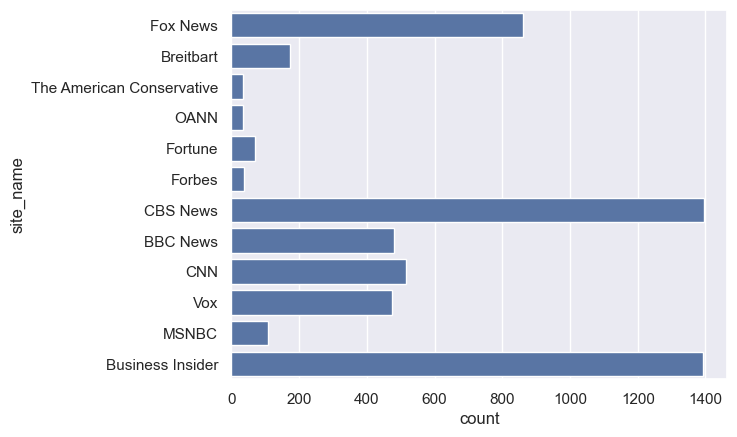

In [62]:
sns.countplot(y=all_news_articles['site_name'])

In [63]:
test = all_news_articles.dropna(subset=['authors'])
test = test[test['authors'].apply(lambda x: len(x) > 0)]
test

,title,authors,publish_date,text,top_image,article,site,site_name,bias
7,Insiders predict this possible Trump VP pick p...,[Brandon Gillespie],None,Editor's note: This is the fourth in a series ...,https://static.foxnews.com/foxnews.com/content...,https://www.foxnews.com/politics/insiders-pred...,fox_news,Fox News,Right
8,Balance of Power: Messy GOP primaries could bo...,[Julia Johnson],None,Republicans are looking to take advantage of a...,https://static.foxnews.com/foxnews.com/content...,https://www.foxnews.com/politics/balance-power...,fox_news,Fox News,Right
9,Hunter Biden is prepping for his federal gun t...,[Brooke Singman],None,Hunter Biden is preparing for his first crimin...,https://static.foxnews.com/foxnews.com/content...,https://www.foxnews.com/politics/hunter-biden-...,fox_news,Fox News,Right
10,Tales from The Trail: Trump 'unleashed' with c...,"[Paul Steinhauser, Paul Steinhauser Is A Polit...",None,Donald Trump is wasting no time in getting bac...,https://static.foxnews.com/foxnews.com/content...,https://www.foxnews.com/politics/tales-from-tr...,fox_news,Fox News,Right
11,Trump guilty verdict reveals split among forme...,[Brandon Gillespie Andrew Miller],None,Former President Donald Trump's Republican pre...,https://static.foxnews.com/foxnews.com/content...,https://www.foxnews.com/politics/trump-guilty-...,fox_news,Fox News,Right
...,...,...,...,...,...,...,...,...,...
5571,Ukraine's Attacks on Russia's Black Sea Fleet ...,"[Sam Fellman, Lilian Manansala]",2024-05-31 00:00:00,Ukraine is facing off against Russia's formida...,https://i.insider.com/665a2062cc442a2f676cdb35...,https://www.businessinsider.com/ukraine-russia...,business_insider,Business Insider,Left
5572,Trump Found Guilty on All Charges in Hush Mone...,"[Erica Star Domena, Tamara Lindstrom]",2024-05-30 00:00:00,A Manhattan jury found Donald Trump guilty of ...,https://i.insider.com/665909441cd3b1779041eaae...,https://www.businessinsider.com/trump-guilty-f...,business_insider,Business Insider,Left
5573,Record-Breaking 127 Degree Heat Wave Hits Indi...,"[Erica Star Domena, Tamara Lindstrom]",2024-05-30 00:00:00,This story is available exclusively to Busines...,https://i.insider.com/6658d9d9d0b8e1c832ca7295...,https://www.businessinsider.com/india-delhi-he...,business_insider,Business Insider,Left
5574,Locals Dig by Hand in Search for Landslide Vic...,"[Erica Star Domena, Tamara Lindstrom]",2024-05-28 00:00:00,A landslide struck Papua New Guinea in the mid...,https://i.insider.com/66562766239fda2da6cc3cdf...,https://www.businessinsider.com/landslide-papu...,business_insider,Business Insider,Left


In [77]:
articles_data = []

for i, site in enumerate(tqdm(sites['link'], desc='Processing sites')):
    try:
        paper = newspaper.build(site, memoize_articles=False)
    except Exception as e:
        print(f"Failed to build newspaper for site {site}: {e}")
        continue

    for links in tqdm(paper.articles, desc=f'Processing articles from {site}', leave=False):
        article = Article(links.url)
        try:
            article.download()
            article.parse()
            articles_data.append({'title': article.title, 'authors': article.authors, 'publish_date':article.publish_date, 'text': article.text, 'top_image':article.top_image, 'article': links.url, 'site': site, 'site_name': sites.loc[i, 'name'], 'bias': sites.loc[i, 'affiliation']})

        except ArticleException as e:
            print(f"ArticleException for {links.url}: {e}")
            continue
        except Exception as e:
            print(f"Unexpected exception for {links.url}: {e}")
            continue


all_news_articles = pd.DataFrame(articles_data)
all_news_articles

Processing sites:   0%|          | 0/13 [00:00<?, ?it/s]

ArticleException for https://help.fox.com/s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-Roku: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-Roku (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-Roku
ArticleException for https://help.fox.com/s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-Apple-TV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-Apple-TV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issu

ArticleException for https://help.fox.com/s/article/How-do-I-watch-FOX-Nation-on-Samsung-TV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-do-I-watch-FOX-Nation-on-Samsung-TV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-do-I-watch-FOX-Nation-on-Samsung-TV
ArticleException for https://help.fox.com/s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-FireTV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-FireTV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/

ArticleException for https://help.fox.com/s/article/How-can-I-watch-FOX-Nation-on-my-Android-TV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-can-I-watch-FOX-Nation-on-my-Android-TV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-can-I-watch-FOX-Nation-on-my-Android-TV
ArticleException for https://help.fox.com/s/article/How-do-I-watch-FOX-Nation-on-a-Vizio-Smart-TV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-do-I-watch-FOX-Nation-on-a-Vizio-Smart-TV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-do-I

ArticleException for https://help.fox.com/s/article/How-do-I-watch-FOX-Nation-on-LG-Smart-TV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-do-I-watch-FOX-Nation-on-LG-Smart-TV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-do-I-watch-FOX-Nation-on-LG-Smart-TV
ArticleException for https://help.fox.com/s/article/How-can-I-stream-FOX-Nation: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-can-I-stream-FOX-Nation (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-can-I-stream-FOX-Nation


ArticleException for https://help.fox.com/s/article/How-do-I-Watch-Fox-News-on-Fox-Nation: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-do-I-Watch-Fox-News-on-Fox-Nation (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-do-I-Watch-Fox-News-on-Fox-Nation


ArticleException for https://www.foxnews.com/video/shows/media-buzz: Article `download()` failed with HTTPSConnectionPool(host='www.foxnews.com', port=443): Read timed out. (read timeout=7) on URL https://www.foxnews.com/video/shows/media-buzz


Processing sites:  62%|██████▏   | 8/13 [26:40<25:44, 308.90s/it]  

ArticleException for https://cms.cnn.com/politics/live-news/trump-hush-money-trial-05-30-24/index.html: Article `download()` failed with HTTPSConnectionPool(host='cms.cnn.com', port=443): Max retries exceeded with url: /politics/live-news/trump-hush-money-trial-05-30-24/index.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x39edb9340>, 'Connection to cms.cnn.com timed out. (connect timeout=7)')) on URL https://cms.cnn.com/politics/live-news/trump-hush-money-trial-05-30-24/index.html


ArticleException for https://www.cnn.com/cnn-underscored/deals/sonos-sale-2024-05-30: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/deals/sonos-sale-2024-05-30 on URL https://www.cnn.com/cnn-underscored/deals/sonos-sale-2024-05-30
ArticleException for https://www.cnn.com/cnn-underscored/travel/how-i-traveled-europe-with-just-backpack: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/travel/how-i-traveled-europe-with-just-backpack on URL https://www.cnn.com/cnn-underscored/travel/how-i-traveled-europe-with-just-backpack


ArticleException for https://www.cnn.com/cnn-underscored/reviews/the-ordinary-niacinamide-vs-medik8-clarity-peptides: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/reviews/the-ordinary-niacinamide-vs-medik8-clarity-peptides on URL https://www.cnn.com/cnn-underscored/reviews/the-ordinary-niacinamide-vs-medik8-clarity-peptides
ArticleException for https://www.cnn.com/cnn-underscored/fashion/best-walking-sandals-for-women-men: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/fashion/best-walking-sandals-for-women-men on URL https://www.cnn.com/cnn-underscored/fashion/best-walking-sandals-for-women-men


ArticleException for https://www.cnn.com/cnn-underscored/deals/best-amazon-deals-2024-05-29: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/deals/best-amazon-deals-2024-05-29 on URL https://www.cnn.com/cnn-underscored/deals/best-amazon-deals-2024-05-29
ArticleException for https://www.cnn.com/cnn-underscored/deals/apple-macbook-pro-m3-sale-2024-05-30: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/deals/apple-macbook-pro-m3-sale-2024-05-30 on URL https://www.cnn.com/cnn-underscored/deals/apple-macbook-pro-m3-sale-2024-05-30


ArticleException for https://www.cnn.com/cnn-underscored/reviews/lululemon-vs-alo-yoga-tennis-skirt: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/reviews/lululemon-vs-alo-yoga-tennis-skirt on URL https://www.cnn.com/cnn-underscored/reviews/lululemon-vs-alo-yoga-tennis-skirt
ArticleException for https://www.cnn.com/cnn-underscored/reviews/dyson-v12-vs-bissell-icon-pet: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/reviews/dyson-v12-vs-bissell-icon-pet on URL https://www.cnn.com/cnn-underscored/reviews/dyson-v12-vs-bissell-icon-pet


ArticleException for https://www.cnn.com/cnn-underscored/deals/apple-ipad-air-sale-2024-05-29: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/deals/apple-ipad-air-sale-2024-05-29 on URL https://www.cnn.com/cnn-underscored/deals/apple-ipad-air-sale-2024-05-29


ArticleException for https://us.cnn.com/cnn-underscored/deals/sonos-sale-2024-05-30: Article `download()` failed with 403 Client Error: Forbidden for url: https://us.cnn.com/cnn-underscored/deals/sonos-sale-2024-05-30 on URL https://us.cnn.com/cnn-underscored/deals/sonos-sale-2024-05-30
ArticleException for https://us.cnn.com/cnn-underscored/travel/how-i-traveled-europe-with-just-backpack: Article `download()` failed with 403 Client Error: Forbidden for url: https://us.cnn.com/cnn-underscored/travel/how-i-traveled-europe-with-just-backpack on URL https://us.cnn.com/cnn-underscored/travel/how-i-traveled-europe-with-just-backpack


ArticleException for https://us.cnn.com/cnn-underscored/reviews/the-ordinary-niacinamide-vs-medik8-clarity-peptides: Article `download()` failed with 403 Client Error: Forbidden for url: https://us.cnn.com/cnn-underscored/reviews/the-ordinary-niacinamide-vs-medik8-clarity-peptides on URL https://us.cnn.com/cnn-underscored/reviews/the-ordinary-niacinamide-vs-medik8-clarity-peptides
ArticleException for https://us.cnn.com/cnn-underscored/fashion/best-walking-sandals-for-women-men: Article `download()` failed with 403 Client Error: Forbidden for url: https://us.cnn.com/cnn-underscored/fashion/best-walking-sandals-for-women-men on URL https://us.cnn.com/cnn-underscored/fashion/best-walking-sandals-for-women-men


ArticleException for https://us.cnn.com/cnn-underscored/deals/best-amazon-deals-2024-05-29: Article `download()` failed with 403 Client Error: Forbidden for url: https://us.cnn.com/cnn-underscored/deals/best-amazon-deals-2024-05-29 on URL https://us.cnn.com/cnn-underscored/deals/best-amazon-deals-2024-05-29
ArticleException for https://us.cnn.com/cnn-underscored/deals/apple-macbook-pro-m3-sale-2024-05-30: Article `download()` failed with 403 Client Error: Forbidden for url: https://us.cnn.com/cnn-underscored/deals/apple-macbook-pro-m3-sale-2024-05-30 on URL https://us.cnn.com/cnn-underscored/deals/apple-macbook-pro-m3-sale-2024-05-30


ArticleException for https://us.cnn.com/cnn-underscored/reviews/lululemon-vs-alo-yoga-tennis-skirt: Article `download()` failed with 403 Client Error: Forbidden for url: https://us.cnn.com/cnn-underscored/reviews/lululemon-vs-alo-yoga-tennis-skirt on URL https://us.cnn.com/cnn-underscored/reviews/lululemon-vs-alo-yoga-tennis-skirt
ArticleException for https://us.cnn.com/cnn-underscored/reviews/dyson-v12-vs-bissell-icon-pet: Article `download()` failed with 403 Client Error: Forbidden for url: https://us.cnn.com/cnn-underscored/reviews/dyson-v12-vs-bissell-icon-pet on URL https://us.cnn.com/cnn-underscored/reviews/dyson-v12-vs-bissell-icon-pet


ArticleException for https://us.cnn.com/cnn-underscored/deals/apple-ipad-air-sale-2024-05-29: Article `download()` failed with 403 Client Error: Forbidden for url: https://us.cnn.com/cnn-underscored/deals/apple-ipad-air-sale-2024-05-29 on URL https://us.cnn.com/cnn-underscored/deals/apple-ipad-air-sale-2024-05-29


Processing sites:  92%|█████████▏| 12/13 [35:28<02:36, 156.82s/it]

ArticleException for https://www.businessinsider.de/karriere/international-career/befoerderung-wurde-abgelehnt-das-habe-ich-danach-veraendert/: Article `download()` failed with HTTPSConnectionPool(host='www.businessinsider.de', port=443): Read timed out. (read timeout=7) on URL https://www.businessinsider.de/karriere/international-career/befoerderung-wurde-abgelehnt-das-habe-ich-danach-veraendert/


ArticleException for https://www.businessinsider.de/karriere/durchschnittseinkommen-so-gross-sind-unterschiede-in-gehaeltern-in-deutschland/: Article `download()` failed with HTTPSConnectionPool(host='www.businessinsider.de', port=443): Read timed out. (read timeout=7) on URL https://www.businessinsider.de/karriere/durchschnittseinkommen-so-gross-sind-unterschiede-in-gehaeltern-in-deutschland/


ArticleException for https://www.businessinsider.jp/feature/blue-planet/: Article `download()` failed with HTTPSConnectionPool(host='www.businessinsider.jp', port=443): Read timed out. (read timeout=7) on URL https://www.businessinsider.jp/feature/blue-planet/


ArticleException for https://www.businessinsider.in/economy/news: Article `download()` failed with 404 Client Error: Not Found for url: https://www.businessinsider.com/economy/news?IR=T on URL https://www.businessinsider.in/economy/news


Processing sites: 100%|██████████| 13/13 [49:23<00:00, 227.98s/it]


,title,authors,publish_date,text,top_image,movies,article,site,site_name,bias,keywords,summary
0,Watch Fox News Channel Online,[],None,Log in to comment on videos and join in on the...,https://a57.foxnews.com/cf-images.us-east-1.pr...,[],https://www.foxnews.com/video/5614615980001,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[join, fun, comment, videos, channel, watch, l...",Log in to comment on videos and join in on the...
2,Entertainment Videos and Video Clips,[],None,Log in to comment on videos and join in on the...,https://static.foxnews.com/static/orion/styles...,[],https://www.foxnews.com/video/topics/entertain...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[join, fun, comment, videos, entertainment, lo...",Log in to comment on videos and join in on the...
4,Fox News Shows,[],None,Log in to comment on videos and join in on the...,https://static.foxnews.com/static/orion/styles...,[],https://www.foxnews.com/video/shows,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[warns, spare, know, higher, different, linger...",Related storiesDimon warned against dismissing...
11080,Why I quit Goldman Sachs,[Lindsay Macmillan],2024-05-21 00:00:00,Goldman Sachs has a problem.\n\nOnly 29% of th...,https://i.insider.com/664613e49fc063e829b1a3db...,[],https://www.businessinsider.com/women-leaving-...,https://www.businessinsider.com/politics,Business Insider,Left,NaN,NaN
11081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[work, women, sachs, companies, left, quit, se...",But as I watch senior women continue their exo...
11082,A Gen Xer who barely lives above the poverty l...,[Allie Kelly],2024-05-21 00:00:00,"By clicking “Sign Up”, you accept our Terms of...",https://i.insider.com/664b6b429fc063e829b2cc88...,[],https://www.businessinsider.com/rent-healthcar...,https://www.businessinsider.com/politics,Business Insider,Left,NaN,NaN


## Filtering Scraped Articles

In [79]:
news_filtered = all_news_articles.dropna(subset=['authors'])
news_filtered = news_filtered[news_filtered['authors'].apply(lambda x: len(x) > 0)]
news_filtered

,title,authors,publish_date,text,top_image,movies,article,site,site_name,bias,keywords,summary
12,Supreme Court rules in favor of NRA in key Fir...,[Brianna Herlihy],None,The Supreme Court on Thursday unanimously deci...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/supreme-court...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
14,Jury resumes deliberations in NY v. Trump trial,"[Posted Michael Lee, Posted Brianna Herlihy, P...",None,Trump trial changes the way we have to campaig...,https://livenews.foxnews.com/images/2024/05/ff...,[],https://www.foxnews.com/live-news/may-30-trump...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
16,DOJ reaches settlement with ex-FBI 'lovebirds'...,[Jamie Joseph],None,Former FBI officials Peter Strzok and Lisa Pag...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/doj-reaches-s...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
18,New poll reveals Biden losing support from thi...,"[Paul Steinhauser, Paul Steinhauser Is A Polit...",None,A new national poll is the latest to suggest t...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/new-poll-poin...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
20,'History of anger problems': Jill Biden mocked...,[Andrew Miller Adam Shaw],None,First lady Jill Biden was blasted on social me...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/jill-biden-mo...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11074,Jamie Dimon might finally be ready to call it ...,[Dan Defrancesco],2024-05-21 00:00:00,"By clicking “Sign Up”, you accept our Terms of...",https://i.insider.com/661456763f923f7dab05b37e...,[],https://www.businessinsider.com/jamie-dimon-re...,https://www.businessinsider.com/politics,Business Insider,Left,NaN,NaN
11076,America's highest-earning CEO was awarded a st...,[George Glover],2024-05-21 00:00:00,Broadcom boss Hock Tan is the highest-earning ...,https://i.insider.com/664c7ec59fc063e829b320e8...,[],https://www.businessinsider.com/who-is-highest...,https://www.businessinsider.com/politics,Business Insider,Left,NaN,NaN
11078,Jamie Dimon warns inflation and higher interes...,[Theron Mohamed],2024-05-21 00:00:00,"By clicking “Sign Up”, you accept our Terms of...",https://i.insider.com/664c78f514fb5b23cc5e8fd9...,[],https://www.businessinsider.com/jamie-dimon-jp...,https://www.businessinsider.com/politics,Business Insider,Left,NaN,NaN
11080,Why I quit Goldman Sachs,[Lindsay Macmillan],2024-05-21 00:00:00,Goldman Sachs has a problem.\n\nOnly 29% of th...,https://i.insider.com/664613e49fc063e829b1a3db...,[],https://www.businessinsider.com/women-leaving-...,https://www.businessinsider.com/politics,Business Insider,Left,NaN,NaN


### See bias distribution

<Axes: xlabel='count', ylabel='bias'>

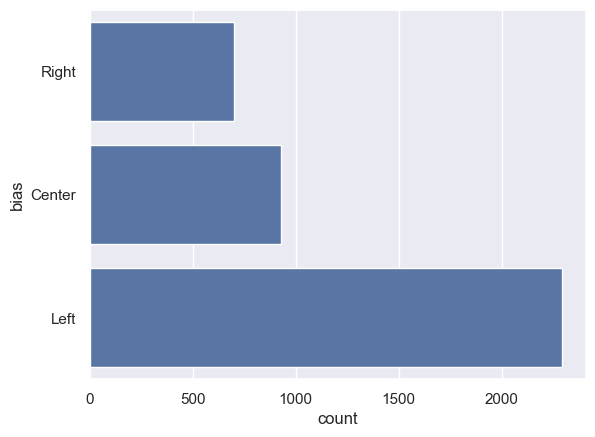

In [80]:
sns.countplot(y=news_filtered['bias'])

In [81]:
news_filtered['bias'].value_counts()

bias
Left      2291
Center     928
Right      703
Name: count, dtype: int64

### Make sure there are the same number of each bias

In [82]:
df_filtered = news_filtered.groupby('bias').head(703).reset_index(drop=True)
df_filtered

,title,authors,publish_date,text,top_image,movies,article,site,site_name,bias,keywords,summary
0,Supreme Court rules in favor of NRA in key Fir...,[Brianna Herlihy],None,The Supreme Court on Thursday unanimously deci...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/supreme-court...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
1,Jury resumes deliberations in NY v. Trump trial,"[Posted Michael Lee, Posted Brianna Herlihy, P...",None,Trump trial changes the way we have to campaig...,https://livenews.foxnews.com/images/2024/05/ff...,[],https://www.foxnews.com/live-news/may-30-trump...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
2,DOJ reaches settlement with ex-FBI 'lovebirds'...,[Jamie Joseph],None,Former FBI officials Peter Strzok and Lisa Pag...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/doj-reaches-s...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
3,New poll reveals Biden losing support from thi...,"[Paul Steinhauser, Paul Steinhauser Is A Polit...",None,A new national poll is the latest to suggest t...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/new-poll-poin...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
4,'History of anger problems': Jill Biden mocked...,[Andrew Miller Adam Shaw],None,First lady Jill Biden was blasted on social me...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/jill-biden-mo...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2104,The NRA just won a big Supreme Court victory. ...,[Ian Millhiser],2024-05-30 16:45:38+00:00,"is a senior correspondent at Vox, where he foc...",https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/scotus/352598/supreme-court-nra...,https://www.vox.com/,Vox,Left,NaN,NaN
2105,Expecting worse: Giving birth on a planet in c...,[Paige Vega],2024-05-30 08:30:00+00:00,Expecting Worse: Giving birth on a planet in c...,https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/climate/351533/expecting-worse-...,https://www.vox.com/,Vox,Left,NaN,NaN
2106,Why the uncanny “All eyes on Rafah” image went...,[Rebecca Jennings],2024-05-29 23:30:00+00:00,is a senior correspondent covering social plat...,https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/internet-culture/352469/viral-e...,https://www.vox.com/,Vox,Left,NaN,NaN
2107,Congress’s tricky attempts to address children...,[A.W. Ohlheiser],2024-05-30 11:00:00+00:00,"is a senior technology reporter at Vox, writin...",https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/technology/352251/kosa-congress...,https://www.vox.com/,Vox,Left,NaN,NaN


## Load Filtered News Articles (Skip to Here)

In [3]:
df_filtered = pd.read_csv("filtered_news_articles.csv")
df_filtered

,title,authors,text,article,site,site_name,bias
0,NY v Trump: Michael Cohen admits to stealing t...,['Emma Colton'],Former Trump attorney Michael Cohen admitted i...,https://www.foxnews.com/politics/ny-v-trump-mi...,https://www.foxnews.com/politics,Fox News,Right
1,Louisiana governor poised to sign stringent tr...,['Charles Creitz'],The Louisiana House and Senate became the late...,https://www.foxnews.com/politics/louisiana-pas...,https://www.foxnews.com/politics,Fox News,Right
2,Biden suggests he was vice president during CO...,['Charles Creitz'],Join Fox News for access to this content Plus ...,https://www.foxnews.com/politics/biden-suggest...,https://www.foxnews.com/politics,Fox News,Right
3,Biden slams ICC’s ‘outrageous’ request for Net...,['Greg Norman'],President Biden is condemning the Internationa...,https://www.foxnews.com/politics/biden-slams-i...,https://www.foxnews.com/politics,Fox News,Right
4,NY v. Trump: Prosecution rests case against Tr...,"['Posted Brandon Gillespie', 'Posted Anders Ha...",Who is Robert Costello?\n\nRobert Costello is ...,https://www.foxnews.com/live-news/may-20-trump...,https://www.foxnews.com/politics,Fox News,Right
...,...,...,...,...,...,...,...
2023,Don’t sneer at white rural voters — or delude ...,"['Eric Levitz', 'Edward Vega', 'Anna North', '...","White rural Americans are a “racist, xenophobi...",https://www.vox.com/politics/24128478/white-ru...,https://www.vox.com/,Vox,Left
2024,How to be enough,"['Allie Volpe', 'Apr']","Recently, psychologist Maytal Eyal has observe...",https://www.vox.com/the-highlight/24091379/how...,https://www.vox.com/,Vox,Left
2025,The Vatican’s new statement on trans rights un...,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",A new Vatican document released April 8 detail...,https://www.vox.com/24126650/vatican-dignity-t...,https://www.vox.com/,Vox,Left
2026,How solar eclipse tourism became big business,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",The biggest US travel event of this year might...,https://www.vox.com/travel/2024/4/4/24120289/s...,https://www.vox.com/,Vox,Left


### Clean Up Scraped Text

In [83]:
df_filtered['clean_text'] = df_filtered['text'].apply(lambda x: str(x).lower())
df_filtered

,title,authors,publish_date,text,top_image,movies,article,site,site_name,bias,keywords,summary,clean_text
0,Supreme Court rules in favor of NRA in key Fir...,[Brianna Herlihy],None,The Supreme Court on Thursday unanimously deci...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/supreme-court...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,the supreme court on thursday unanimously deci...
1,Jury resumes deliberations in NY v. Trump trial,"[Posted Michael Lee, Posted Brianna Herlihy, P...",None,Trump trial changes the way we have to campaig...,https://livenews.foxnews.com/images/2024/05/ff...,[],https://www.foxnews.com/live-news/may-30-trump...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,trump trial changes the way we have to campaig...
2,DOJ reaches settlement with ex-FBI 'lovebirds'...,[Jamie Joseph],None,Former FBI officials Peter Strzok and Lisa Pag...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/doj-reaches-s...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,former fbi officials peter strzok and lisa pag...
3,New poll reveals Biden losing support from thi...,"[Paul Steinhauser, Paul Steinhauser Is A Polit...",None,A new national poll is the latest to suggest t...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/new-poll-poin...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,a new national poll is the latest to suggest t...
4,'History of anger problems': Jill Biden mocked...,[Andrew Miller Adam Shaw],None,First lady Jill Biden was blasted on social me...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/jill-biden-mo...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,first lady jill biden was blasted on social me...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,The NRA just won a big Supreme Court victory. ...,[Ian Millhiser],2024-05-30 16:45:38+00:00,"is a senior correspondent at Vox, where he foc...",https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/scotus/352598/supreme-court-nra...,https://www.vox.com/,Vox,Left,NaN,NaN,"is a senior correspondent at vox, where he foc..."
2105,Expecting worse: Giving birth on a planet in c...,[Paige Vega],2024-05-30 08:30:00+00:00,Expecting Worse: Giving birth on a planet in c...,https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/climate/351533/expecting-worse-...,https://www.vox.com/,Vox,Left,NaN,NaN,expecting worse: giving birth on a planet in c...
2106,Why the uncanny “All eyes on Rafah” image went...,[Rebecca Jennings],2024-05-29 23:30:00+00:00,is a senior correspondent covering social plat...,https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/internet-culture/352469/viral-e...,https://www.vox.com/,Vox,Left,NaN,NaN,is a senior correspondent covering social plat...
2107,Congress’s tricky attempts to address children...,[A.W. Ohlheiser],2024-05-30 11:00:00+00:00,"is a senior technology reporter at Vox, writin...",https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/technology/352251/kosa-congress...,https://www.vox.com/,Vox,Left,NaN,NaN,"is a senior technology reporter at vox, writin..."


In [84]:
for i, row in enumerate(df_filtered['clean_text']):
    df_filtered.loc[i, 'clean_text'] = ' '.join([word for word in row.split() if word not in en_stopwords])
df_filtered

,title,authors,publish_date,text,top_image,movies,article,site,site_name,bias,keywords,summary,clean_text
0,Supreme Court rules in favor of NRA in key Fir...,[Brianna Herlihy],None,The Supreme Court on Thursday unanimously deci...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/supreme-court...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,supreme court thursday unanimously decided nat...
1,Jury resumes deliberations in NY v. Trump trial,"[Posted Michael Lee, Posted Brianna Herlihy, P...",None,Trump trial changes the way we have to campaig...,https://livenews.foxnews.com/images/2024/05/ff...,[],https://www.foxnews.com/live-news/may-30-trump...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,trump trial changes way campaign: rnc chair mi...
2,DOJ reaches settlement with ex-FBI 'lovebirds'...,[Jamie Joseph],None,Former FBI officials Peter Strzok and Lisa Pag...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/doj-reaches-s...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,former fbi officials peter strzok lisa page se...
3,New poll reveals Biden losing support from thi...,"[Paul Steinhauser, Paul Steinhauser Is A Polit...",None,A new national poll is the latest to suggest t...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/new-poll-poin...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,new national poll latest suggest president bid...
4,'History of anger problems': Jill Biden mocked...,[Andrew Miller Adam Shaw],None,First lady Jill Biden was blasted on social me...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/jill-biden-mo...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,first lady jill biden blasted social media wed...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,The NRA just won a big Supreme Court victory. ...,[Ian Millhiser],2024-05-30 16:45:38+00:00,"is a senior correspondent at Vox, where he foc...",https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/scotus/352598/supreme-court-nra...,https://www.vox.com/,Vox,Left,NaN,NaN,"senior correspondent vox, focuses supreme cour..."
2105,Expecting worse: Giving birth on a planet in c...,[Paige Vega],2024-05-30 08:30:00+00:00,Expecting Worse: Giving birth on a planet in c...,https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/climate/351533/expecting-worse-...,https://www.vox.com/,Vox,Left,NaN,NaN,expecting worse: giving birth planet crisis co...
2106,Why the uncanny “All eyes on Rafah” image went...,[Rebecca Jennings],2024-05-29 23:30:00+00:00,is a senior correspondent covering social plat...,https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/internet-culture/352469/viral-e...,https://www.vox.com/,Vox,Left,NaN,NaN,senior correspondent covering social platforms...
2107,Congress’s tricky attempts to address children...,[A.W. Ohlheiser],2024-05-30 11:00:00+00:00,"is a senior technology reporter at Vox, writin...",https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/technology/352251/kosa-congress...,https://www.vox.com/,Vox,Left,NaN,NaN,"senior technology reporter vox, writing impact..."


In [85]:
df_filtered['clean_text'] = df_filtered['clean_text'].str.strip()

df_filtered['clean_text'] = df_filtered['clean_text'].str.strip().str.replace(r'[^\w\s]', '', regex=True)

df_filtered

,title,authors,publish_date,text,top_image,movies,article,site,site_name,bias,keywords,summary,clean_text
0,Supreme Court rules in favor of NRA in key Fir...,[Brianna Herlihy],None,The Supreme Court on Thursday unanimously deci...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/supreme-court...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,supreme court thursday unanimously decided nat...
1,Jury resumes deliberations in NY v. Trump trial,"[Posted Michael Lee, Posted Brianna Herlihy, P...",None,Trump trial changes the way we have to campaig...,https://livenews.foxnews.com/images/2024/05/ff...,[],https://www.foxnews.com/live-news/may-30-trump...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,trump trial changes way campaign rnc chair mic...
2,DOJ reaches settlement with ex-FBI 'lovebirds'...,[Jamie Joseph],None,Former FBI officials Peter Strzok and Lisa Pag...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/doj-reaches-s...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,former fbi officials peter strzok lisa page se...
3,New poll reveals Biden losing support from thi...,"[Paul Steinhauser, Paul Steinhauser Is A Polit...",None,A new national poll is the latest to suggest t...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/new-poll-poin...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,new national poll latest suggest president bid...
4,'History of anger problems': Jill Biden mocked...,[Andrew Miller Adam Shaw],None,First lady Jill Biden was blasted on social me...,https://static.foxnews.com/foxnews.com/content...,[],https://www.foxnews.com/politics/jill-biden-mo...,https://www.foxnews.com/politics,Fox News,Right,NaN,NaN,first lady jill biden blasted social media wed...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,The NRA just won a big Supreme Court victory. ...,[Ian Millhiser],2024-05-30 16:45:38+00:00,"is a senior correspondent at Vox, where he foc...",https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/scotus/352598/supreme-court-nra...,https://www.vox.com/,Vox,Left,NaN,NaN,senior correspondent vox focuses supreme court...
2105,Expecting worse: Giving birth on a planet in c...,[Paige Vega],2024-05-30 08:30:00+00:00,Expecting Worse: Giving birth on a planet in c...,https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/climate/351533/expecting-worse-...,https://www.vox.com/,Vox,Left,NaN,NaN,expecting worse giving birth planet crisis col...
2106,Why the uncanny “All eyes on Rafah” image went...,[Rebecca Jennings],2024-05-29 23:30:00+00:00,is a senior correspondent covering social plat...,https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/internet-culture/352469/viral-e...,https://www.vox.com/,Vox,Left,NaN,NaN,senior correspondent covering social platforms...
2107,Congress’s tricky attempts to address children...,[A.W. Ohlheiser],2024-05-30 11:00:00+00:00,"is a senior technology reporter at Vox, writin...",https://platform.vox.com/wp-content/uploads/si...,[],http://vox.com/technology/352251/kosa-congress...,https://www.vox.com/,Vox,Left,NaN,NaN,senior technology reporter vox writing impact ...


## Transformations

In [86]:
test_df = df_filtered.copy()

label_encoder = LabelEncoder()
test_df['bias'] = label_encoder.fit_transform(test_df['bias'])
test_df

test_df.to_csv("transformed_articles.csv", index=False)

### Split the Data

In [87]:
X_train, X_test, y_train, y_test = train_test_split(test_df['clean_text'], test_df['bias'], test_size=0.2, stratify=test_df['bias'], random_state=42)
X_test

1550    cnn  dupont de nemours american multinational ...
329     day history may 30 1868 first decoration day  ...
1862    part vox media voxcom adheres vox media editor...
1827    senior technology reporter vox writing impact ...
1779    mira cómo este volcán islandés escupe lava 031...
                              ...                        
1410    cnn  bipartisan pair us senators pressuring bi...
1968    senior technology reporter vox writing impact ...
1391    adults aging faster  higher risk early onset c...
1388    david schechter national environmental corresp...
2049    recently psychologist maytal eyal observed cal...
Name: clean_text, Length: 422, dtype: object

### Vectorize Text (TF-IDF)

In [88]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

tfidf_filename = 'trained_models/tfidf_vectorizer.joblib'
joblib.dump(tfidf, tfidf_filename)


['tfidf_vectorizer.joblib']

### Logistic Regression

In [89]:
# Model training
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Model evaluation
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.8909952606635071
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       140
           1       0.85      0.91      0.88       141
           2       0.96      0.89      0.92       141

    accuracy                           0.89       422
   macro avg       0.89      0.89      0.89       422
weighted avg       0.89      0.89      0.89       422



### Support Vector Machine (SVM)

In [90]:
model = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.8957345971563981
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       140
           1       0.86      0.92      0.89       141
           2       0.98      0.88      0.93       141

    accuracy                           0.90       422
   macro avg       0.90      0.90      0.90       422
weighted avg       0.90      0.90      0.90       422



### Random Forest

In [91]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9407582938388626
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       140
           1       0.92      0.97      0.94       141
           2       0.96      0.94      0.95       141

    accuracy                           0.94       422
   macro avg       0.94      0.94      0.94       422
weighted avg       0.94      0.94      0.94       422



### Gradient Boosting

In [92]:
model = GradientBoostingClassifier()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9502369668246445
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       140
           1       0.99      0.96      0.97       141
           2       0.97      0.91      0.94       141

    accuracy                           0.95       422
   macro avg       0.95      0.95      0.95       422
weighted avg       0.95      0.95      0.95       422



### XGBoost (Best)

In [97]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_tfidf, y_train)

model_filename = 'trained_models/xgboost_model.joblib'
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")




y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Model saved to xgboost_model.joblib
Accuracy: 0.9597156398104265
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       140
           1       0.98      0.97      0.98       141
           2       0.96      0.94      0.95       141

    accuracy                           0.96       422
   macro avg       0.96      0.96      0.96       422
weighted avg       0.96      0.96      0.96       422



## Testing

In [15]:
news_article = 'https://www.cnn.com/2024/05/21/politics/ai-2024-election-interference-dhs-warns/index.html'

first_article = Article(url=news_article)
first_article.download()
first_article.parse()
print(first_article.text)

CNN —

Artificial intelligence tools for creating fake video, audio and other content will likely give foreign operatives and domestic extremists “enhanced opportunities for interference” as the 2024 US election cycle progresses, the Department of Homeland Security said in a recent bulletin distributed to state and local officials and obtained by CNN.

A variety of “threat actors” will likely try to use generative AI — or AI that creates fake content — to influence or “sow discord” during the US election cycle, says the May 17 bulletin, which was produced by the DHS Office of Intelligence and Analysis.

While a “large-scale attack on the election is less likely” because of the “higher risk of detection and the decentralized and diverse nature of the voting system,” the bulletin says, “threat actors might still attempt to conduct limited operations leading to disruptions in key election battleground areas.”

Foreign or domestic operatives could, for example, try to “confuse or overwhelm

In [16]:
def predict_party(text):
    text_tfidf = tfidf.transform([text])
    prediction = model.predict(text_tfidf)
    # Uncomment below for probability distribution for XGBoost
    y_pred_proba = model.predict_proba(text_tfidf)
    print(y_pred_proba)
    return "Left" if prediction[0] == 1 else "Right" if prediction[0] == 2 else "Center"

new_article = first_article.text
predicted_party = predict_party(new_article)
print(f'The predicted party affiliation is: {predicted_party}')

[[0.21970676 0.77856493 0.00172831]]
The predicted party affiliation is: Left


In [17]:
test_df

,title,authors,text,article,site,site_name,bias,clean_text
0,NY v Trump: Michael Cohen admits to stealing t...,['Emma Colton'],Former Trump attorney Michael Cohen admitted i...,https://www.foxnews.com/politics/ny-v-trump-mi...,https://www.foxnews.com/politics,Fox News,2,former trump attorney michael cohen admitted t...
1,Louisiana governor poised to sign stringent tr...,['Charles Creitz'],The Louisiana House and Senate became the late...,https://www.foxnews.com/politics/louisiana-pas...,https://www.foxnews.com/politics,Fox News,2,louisiana house senate became latest state leg...
2,Biden suggests he was vice president during CO...,['Charles Creitz'],Join Fox News for access to this content Plus ...,https://www.foxnews.com/politics/biden-suggest...,https://www.foxnews.com/politics,Fox News,2,join fox news access content plus special acce...
3,Biden slams ICC’s ‘outrageous’ request for Net...,['Greg Norman'],President Biden is condemning the Internationa...,https://www.foxnews.com/politics/biden-slams-i...,https://www.foxnews.com/politics,Fox News,2,president biden condemning international crimi...
4,NY v. Trump: Prosecution rests case against Tr...,"['Posted Brandon Gillespie', 'Posted Anders Ha...",Who is Robert Costello?\n\nRobert Costello is ...,https://www.foxnews.com/live-news/may-20-trump...,https://www.foxnews.com/politics,Fox News,2,robert costello robert costello former legal a...
...,...,...,...,...,...,...,...,...
2023,Don’t sneer at white rural voters — or delude ...,"['Eric Levitz', 'Edward Vega', 'Anna North', '...","White rural Americans are a “racist, xenophobi...",https://www.vox.com/politics/24128478/white-ru...,https://www.vox.com/,Vox,1,white rural americans racist xenophobic antiim...
2024,How to be enough,"['Allie Volpe', 'Apr']","Recently, psychologist Maytal Eyal has observe...",https://www.vox.com/the-highlight/24091379/how...,https://www.vox.com/,Vox,1,recently psychologist maytal eyal observed cal...
2025,The Vatican’s new statement on trans rights un...,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",A new Vatican document released April 8 detail...,https://www.vox.com/24126650/vatican-dignity-t...,https://www.vox.com/,Vox,1,new vatican document released april 8 details ...
2026,How solar eclipse tourism became big business,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",The biggest US travel event of this year might...,https://www.vox.com/travel/2024/4/4/24120289/s...,https://www.vox.com/,Vox,1,biggest us travel event year might taylor swif...


In [18]:
test_df['text'][66]

'Join Fox News for access to this content Plus special access to select articles and other premium content with your account - free of charge. Please enter a valid email address.\n\nMexico\'s "most powerful and ruthless" cartels operate in all 50 states and clash in American cities, the U.S. Drug Enforcement Administration said in a May report.\n\nThe Jalisco and Sinaloa cartels have flooded major U.S. cities with meth and fentanyl and use violence to protect their turf, the report found.\n\n"The deadly reach of the Mexican Sinaloa and Jalisco cartels into U.S. communities is extended by the wholesale-level traffickers and street dealers bringing the cartels’ drugs to market, sometimes creating their own deadly drug mixtures," the DEA report says. "Together, the Sinaloa and Jalisco cartels have caused the worst drug crisis in U.S. history."\n\nThe DEA\'s National Drug Threat Assessment report details the cartels\' leadership structures, the areas they control, how they operate and thei

In [98]:
import spacy
from spacy import displacy
from spacy import tokenizer
import re

nlp = spacy.load("en_core_web_sm")

spacy_doc = nlp(test_df['text'][0])

for word in spacy_doc.ents:
    print(word.text, word.label_)

The Supreme Court ORG
Thursday DATE
the National Rifle Association ORG
NRA GPE
the New York State Department of Financial Services ORG
First Amendment LAW
Sonia Sotomayor PERSON
NRA GPE
Department of Financial Services ORG
Superintendent Maria T.] PERSON
the First Amendment LAW
NRA GPE
NRA GPE
the U. S. Court of Appeals ORG
the Second Circuit ORG
NRA GPE
second ORDINAL
NRA GPE
2018 DATE
the First Amendment LAW
Six decades ago DATE
Court ORG
third ORDINAL
the First Amendment LAW
Today DATE
Court ORG
Petitioner National Rifle Association ORG
NRA GPE
Maria Vullo PERSON
NRA GPE
Vullo PERSON
New York GPE
Andrew Cuomo PERSON
NRA GPE
NRA GPE
2018 DATE
NRA GPE
pro-Second NORP
Parkland GPE
Florida GPE
17 CARDINAL
Vullo PERSON
NRA GPE
the New York Department of Financial Services ORG
Vullo PERSON
NRA GPE
NRA GPE
Thursday DATE
NRA GPE
First Amendment LAW
The Supreme Court ORG
November DATE
National Rifle Association of America v. Vullo ORG
2022 DATE
Vullo ORG
Thursday DATE
the Second Circuit ORG


In [101]:
entities = [(word.text, word.label_) for word in spacy_doc.ents]

df = pd.DataFrame(entities, columns=['Entity', 'Label'])
df

,Entity,Label
0,The Supreme Court,ORG
1,Thursday,DATE
2,the National Rifle Association,ORG
3,NRA,GPE
4,the New York State Department of Financial Ser...,ORG
...,...,...
84,Fox News',ORG
85,Shannon Bream,FAC
86,Bill Mears,PERSON
87,Fox News Digital's,ORG


In [45]:
news_article = 'https://www.vox.com/world-politics/351968/the-slaughter-in-rafah-and-israels-moral-nadir'

article1 = Article(url=news_article)
article1.download()
article1.parse()
print(article1.text)

print("--------------------------------------------------------------------------------------")

news_article = 'https://www.nytimes.com/2024/05/28/world/europe/pope-apology-slang-gay-men.html'

article2 = Article(url=news_article)
article2.download()
article2.parse()
print(article2.text)

is a senior correspondent at Vox, where he covers ideology and challenges to democracy, both at home and abroad. His book on democracy,, will publish in July and is currently available for pre-order

Palestinians look at the destruction after an Israeli strike where displaced people were staying in Rafah, in the Gaza Strip on May 27, 2024.

On Sunday, an Israeli airstrike in the Gaza city of Rafah ignited a fire that killed dozens of civilians. The carnage was horrific even by the bloody standards set by Israel’s war: An emergency doctor on the ground told NPR that it was “one of the most horrific massacres to have occurred in recent days here in Rafah and across the Gaza Strip.”

The war is disastrous first and foremost for the Palestinian people. Tens of thousands are dead — an accurate death count is currently impossible — and many others are suffering immensely from injuries, lack of food, and inadequate health care. It is a humanitarian nightmare on an unimaginable scale.

But it 

In [47]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

def calculate_similarity(doc1, doc2):
    entities1 = extract_entities(doc1)
    print(entities1)
    entities2 = extract_entities(doc2)
    print(entities2)
    
    # Convert entity lists to a format suitable for TF-IDF vectorizer
    corpus = [' '.join(entities1), ' '.join(entities2)]
    print(corpus)
    
    # Compute TF-IDF vectors
    vectorizer = TfidfVectorizer().fit_transform(corpus)
    vectors = vectorizer.toarray()
    
    # Compute cosine similarity
    cosine_sim = cosine_similarity(vectors)
    return cosine_sim[0][1]

# Example documents
# doc1 = test_df['text'][66]
# doc2 = test_df['text'][70]

doc1 = article1.text
doc2 = article2.text

similarity_score = calculate_similarity(doc1, doc2)
print(f"Similarity Score: {similarity_score}")



['Vox', 'July', 'Palestinians', 'Israeli', 'Rafah', 'the Gaza Strip', 'May 27, 2024', 'Sunday', 'Israeli', 'Gaza', 'dozens', 'Israel', 'NPR', 'one', 'recent days', 'Rafah', 'the Gaza Strip', 'first', 'Palestinian', 'Tens of thousands', 'Israel', 'Israel', 'the Gaza war', 'one', 'Israel', 'Palestinians', 'Israeli', 'Benjamin Netanyahu', 'Israel', 'Biden', 'Israeli', 'Israeli', 'weekend', 'Rafah', 'two', 'Hamas', 'the Israel Defense Forces', 'Daniel Hagari', 'Israeli', 'Gazans', 'Israeli', 'Rafah', 'the past three weeks', 'nearly a million', 'Palestinians', 'one', 'the weekend', 'hundreds of thousands', 'Gaza', 'this weekend', 'Biden', 'Israeli', 'American', 'Team Biden', 'Israel', 'Rafah', 'Sunday', 'Today', 'Israeli', 'Israel', 'America', 'Biden', 'Gaza', 'Suicide', 'Israeli', 'Hamas', 'Israel', 'Hamas', 'al-Shifa', 'IDF', 'Hamas', 'thousands', 'Israel', 'Israel', 'About two weeks ago', 'Netanyahu', 'October', 'Defense', 'Yoav Gallant', 'May 15', 'The ‘day', 'Hamas', 'Palestinian', 'Ga

In [52]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return ' '.join([ent.text for ent in doc.ents])

def calculate_similarity_matrix(documents):
    # Extract entities from all documents
    entity_docs = [extract_entities(doc) for doc in documents]
    
    # Compute TF-IDF vectors for all documents at once
    vectorizer = TfidfVectorizer().fit_transform(entity_docs)
    
    # Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(vectorizer)
    return cosine_sim_matrix

# Example list of documents
documents = [
    "Apple is looking at buying U.K. startup for $1 billion. Apple has been considering this move for a while.",
    "Apple is considering a purchase of a London-based company for a billion dollars. This acquisition could be significant for Apple.",
    "Google has announced a new version of Windows. The tech giant is investing heavily in AI.",
    "Google is developing a new AI-based search algorithm. This new algorithm could revolutionize the search industry."
]

# Calculate similarity matrix
similarity_matrix = calculate_similarity_matrix(documents)

# Display similarity matrix
similarity_matrix_df = pd.DataFrame(similarity_matrix, index=range(1, len(documents)+1), columns=range(1, len(documents)+1))

# import ace_tools as tools; tools.display_dataframe_to_user(name="Similarity Matrix", dataframe=similarity_matrix_df)

print(similarity_matrix_df)


          1         2        3        4
1  1.000000  0.780035  0.00000  0.00000
2  0.780035  1.000000  0.00000  0.00000
3  0.000000  0.000000  1.00000  0.74445
4  0.000000  0.000000  0.74445  1.00000


In [35]:
test_df = test_df.dropna(subset=['text'])
test_df = test_df.drop_duplicates().reset_index()

In [22]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return ' '.join([ent.text for ent in doc.ents])

def calculate_similarity_matrix(documents):
    entity_docs = [extract_entities(doc) for doc in documents]
    
    vectorizer = TfidfVectorizer().fit_transform(entity_docs)
    
    cosine_sim_matrix = cosine_similarity(vectorizer)
    return cosine_sim_matrix

def filter_similar_pairs(documents, threshold=0.5):
    similarity_matrix = calculate_similarity_matrix(documents)
    num_docs = len(documents)
    
    mask = np.triu(np.ones((num_docs, num_docs)), k=1)
    
    filtered_indices = np.where((similarity_matrix > threshold) & (mask == 1))
    
    similar_pairs = [(i, j, similarity_matrix[i][j]) for i, j in zip(filtered_indices[0], filtered_indices[1])]
    
    return similar_pairs

documents = [
    "Apple is looking at buying U.K. startup for $1 billion. Apple has been considering this move for a while.",
    "Apple is considering a purchase of a London-based company for a billion dollars. This acquisition could be significant for Apple.",
    "Microsoft has announced a new version of Windows. The tech giant is investing heavily in AI.",
    "Google is developing a new AI-based search algorithm. This new algorithm could revolutionize the search industry."
]

similar_pairs = filter_similar_pairs(test_df['text'], threshold=0.5)

# for i, j, score in similar_pairs:
#     if test_df.loc[i, 'bias'] != test_df.loc[j, 'bias']:
#         print(f"Document {i}:{test_df.loc[i, 'bias']} and Document {j}:{test_df.loc[j, 'bias']} have a similarity score of {score:.2f}")

results = []

for i, j, score in similar_pairs:
    if test_df.loc[i, 'bias'] != test_df.loc[j, 'bias']:
        result = {
            'Document1_Index': i,
            'Document1_Bias': test_df.loc[i, 'bias'],
            'Document2_Index': j,
            'Document2_Bias': test_df.loc[j, 'bias'],
            'Similarity_Score': score
        }
        results.append(result)

# Convert list to DataFrame
results_df = pd.DataFrame(results)

results_df.to_csv('article_similarity.csv', index=False)  

results_df


,Document1_Index,Document1_Bias,Document2_Index,Document2_Bias,Similarity_Score
0,0,2,1359,1,0.764408
1,0,2,1362,1,0.787436
2,0,2,1367,1,0.753038
3,0,2,1381,1,0.600815
4,0,2,1502,1,0.743013
...,...,...,...,...,...
1254,1337,0,1452,1,0.878479
1255,1337,0,1488,1,0.878084
1256,1337,0,1570,1,0.878479
1257,1337,0,1597,1,0.878084


In [29]:
clean_results_df = results_df.groupby('Document1_Index', group_keys=False).apply(lambda x: x.sort_values('Similarity_Score', ascending=False).head(5))
clean_results_df

/var/folders/pj/97rwmxpn6nj_jxn73l92m4vr0000gn/T/ipykernel_47248/1891287814.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_results_df = results_df.groupby('Document1_Index', group_keys=False).apply(lambda x: x.sort_values('Similarity_Score', ascending=False).head(5))


,Document1_Index,Document1_Bias,Document2_Index,Document2_Bias,Similarity_Score
1,0,2,1362,1,0.787436
0,0,2,1359,1,0.764408
2,0,2,1367,1,0.753038
4,0,2,1502,1,0.743013
6,0,2,1610,1,0.743013
...,...,...,...,...,...
1254,1337,0,1452,1,0.878479
1256,1337,0,1570,1,0.878479
1255,1337,0,1488,1,0.878084
1257,1337,0,1597,1,0.878084


In [32]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return ' '.join([ent.text for ent in doc.ents])

def calculate_similarity_with_single_document(documents, single_document):
    # Extract entities from all documents
    entity_docs = [extract_entities(doc) for doc in documents]
    
    # Extract entities from the single document
    single_entity_doc = extract_entities(single_document)
    
    # Combine the single document with the list for fitting the vectorizer
    combined_docs = entity_docs + [single_entity_doc]
    
    # Compute TF-IDF vectors for all documents including the single document
    vectorizer = TfidfVectorizer().fit_transform(combined_docs)
    
    # Separate the vector for the single document
    single_doc_vector = vectorizer[-1]
    
    # Compute cosine similarity between the single document and all other documents
    cosine_similarities = cosine_similarity(single_doc_vector, vectorizer[:-1])
    
    return cosine_similarities.flatten()

# Example list of documents
documents = [
    "Apple is looking at buying U.K. startup for $1 billion. Apple has been considering this move for a while.",
    "Apple is considering a purchase of a London-based company for a billion dollars. This acquisition could be significant for Apple.",
    "Microsoft has announced a new version of Windows. The tech giant is investing heavily in AI.",
    "Google is developing a new AI-based search algorithm. This new algorithm could revolutionize the search industry."
]

# Specific document to compare against the list
single_document = "Apple is looking to acquire a startup in London."

# Calculate similarity with the single document
similarities = calculate_similarity_with_single_document(documents, single_document)

# Display similarity scores
for idx, score in enumerate(similarities):
    print(f"Document {idx+1} has a similarity score of {score:.2f} with the single document.")


Document 1 has a similarity score of 0.55 with the single document.
Document 2 has a similarity score of 0.73 with the single document.
Document 3 has a similarity score of 0.00 with the single document.
Document 4 has a similarity score of 0.00 with the single document.


In [40]:
clean_results_df[clean_results_df['Document1_Index'] == 5]

,Document1_Index,Document1_Bias,Document2_Index,Document2_Bias,Similarity_Score
32,5,2,1362,1,0.734948
31,5,2,1359,1,0.734098
33,5,2,1367,1,0.712347
35,5,2,1502,1,0.704367
37,5,2,1610,1,0.704367


In [85]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return ' '.join([ent.text for ent in doc.ents])

def calculate_similarity_matrix(documents):
    entity_docs = [extract_entities(doc) for doc in documents]
    
    vectorizer = TfidfVectorizer().fit_transform(entity_docs)
    
    cosine_sim_matrix = cosine_similarity(vectorizer)
    return cosine_sim_matrix

def filter_similar_pairs(documents, threshold=0.5):
    similarity_matrix = calculate_similarity_matrix(documents)
    num_docs = len(documents)
    
    mask = np.triu(np.ones((num_docs, num_docs)), k=1)
    
    filtered_indices = np.where((similarity_matrix > threshold) & (mask == 1))
    
    similar_pairs = [(i, j, similarity_matrix[i][j]) for i, j in zip(filtered_indices[0], filtered_indices[1])]
    
    return similar_pairs

documents = [
    test_df['text'][0],
    test_df['text'][97]
]

similar_pairs = filter_similar_pairs(documents, threshold=0.5)

for i, j, score in similar_pairs:
    print(f"Document {i} and Document {j} have a similarity score of {score:.2f}")

Document 0 and Document 1 have a similarity score of 0.88


In [110]:
test_df['article'][1337]

'https://www.cbsnews.com/pittsburgh/news/red-lobster-bankruptcy-chapter-11-sale-restaurants/'

In [112]:
test_df['article'][1709]

'https://edition.cnn.com/2024/05/20/business/what-went-wrong-at-red-lobster/index.html'

In [36]:
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return ' '.join([ent.text for ent in doc.ents])

def calculate_similarity_with_single_document(documents, single_document):
    entity_docs = [extract_entities(doc) for doc in documents]
    
    single_entity_doc = extract_entities(single_document)
    
    combined_docs = entity_docs + [single_entity_doc]
    
    vectorizer = TfidfVectorizer().fit_transform(combined_docs)
    
    single_doc_vector = vectorizer[-1]
    
    cosine_similarities = cosine_similarity(single_doc_vector, vectorizer[:-1])
    
    return cosine_similarities.flatten()

single_document = first_article.text

similarities = calculate_similarity_with_single_document(test_df['text'], single_document)



results = []

for idx, score in enumerate(similarities):
    result = {
        'Article': idx,
        'Document1_Bias': test_df.loc[idx, 'bias'],
        'Similarity_Score': score
    }
    results.append(result)

results_df = pd.DataFrame(results)

results_df

,Article,Document1_Bias,Similarity_Score
0,0,2,0.030518
1,1,2,0.039056
2,2,2,0.090393
3,3,2,0.028075
4,4,2,0.018894
...,...,...,...
2015,2015,1,0.089026
2016,2016,1,0.002427
2017,2017,1,0.035715
2018,2018,1,0.110336


In [56]:
two_test

,Document1_Index,Document1_Bias,Document2_Index,Document2_Bias,Similarity_Score
32,5,2,1362,1,0.734948
31,5,2,1359,1,0.734098
33,5,2,1367,1,0.712347
35,5,2,1502,1,0.704367
37,5,2,1610,1,0.704367
40,6,2,1362,1,0.681702
39,6,2,1359,1,0.677151
43,6,2,1502,1,0.658971
44,6,2,1610,1,0.658971
41,6,2,1367,1,0.646844


In [62]:
test_df

,index,title,authors,text,article,site,site_name,bias,clean_text
0,0,NY v Trump: Michael Cohen admits to stealing t...,['Emma Colton'],Former Trump attorney Michael Cohen admitted i...,https://www.foxnews.com/politics/ny-v-trump-mi...,https://www.foxnews.com/politics,Fox News,2,former trump attorney michael cohen admitted t...
1,1,Louisiana governor poised to sign stringent tr...,['Charles Creitz'],The Louisiana House and Senate became the late...,https://www.foxnews.com/politics/louisiana-pas...,https://www.foxnews.com/politics,Fox News,2,louisiana house senate became latest state leg...
2,2,Biden suggests he was vice president during CO...,['Charles Creitz'],Join Fox News for access to this content Plus ...,https://www.foxnews.com/politics/biden-suggest...,https://www.foxnews.com/politics,Fox News,2,join fox news access content plus special acce...
3,3,Biden slams ICC’s ‘outrageous’ request for Net...,['Greg Norman'],President Biden is condemning the Internationa...,https://www.foxnews.com/politics/biden-slams-i...,https://www.foxnews.com/politics,Fox News,2,president biden condemning international crimi...
4,4,NY v. Trump: Prosecution rests case against Tr...,"['Posted Brandon Gillespie', 'Posted Anders Ha...",Who is Robert Costello?\n\nRobert Costello is ...,https://www.foxnews.com/live-news/may-20-trump...,https://www.foxnews.com/politics,Fox News,2,robert costello robert costello former legal a...
...,...,...,...,...,...,...,...,...,...
2015,2023,Don’t sneer at white rural voters — or delude ...,"['Eric Levitz', 'Edward Vega', 'Anna North', '...","White rural Americans are a “racist, xenophobi...",https://www.vox.com/politics/24128478/white-ru...,https://www.vox.com/,Vox,1,white rural americans racist xenophobic antiim...
2016,2024,How to be enough,"['Allie Volpe', 'Apr']","Recently, psychologist Maytal Eyal has observe...",https://www.vox.com/the-highlight/24091379/how...,https://www.vox.com/,Vox,1,recently psychologist maytal eyal observed cal...
2017,2025,The Vatican’s new statement on trans rights un...,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",A new Vatican document released April 8 detail...,https://www.vox.com/24126650/vatican-dignity-t...,https://www.vox.com/,Vox,1,new vatican document released april 8 details ...
2018,2026,How solar eclipse tourism became big business,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",The biggest US travel event of this year might...,https://www.vox.com/travel/2024/4/4/24120289/s...,https://www.vox.com/,Vox,1,biggest us travel event year might taylor swif...


In [72]:
two_test = clean_results_df[(clean_results_df['Document1_Index'] == 5)|(clean_results_df['Document1_Index'] == 6)]

two_test

test_df.loc[two_test['Document1_Index']]

filtered_clean_results_df = two_test[two_test['Document1_Index'] == 6]

# Filter test_df based on filtered_clean_results_df
indices = two_test[two_test['Document1_Index'] == 6]['Document1_Index']

# Use these indices to filter test_df and select the desired columns
filtered_df = test_df.loc[indices, ['index', 'title', 'authors', 'article']]


filtered_df = filtered_df.merge(two_test[two_test['Document1_Index'] == 6][['Document1_Index', 'Similarity_Score']], left_on='index', right_on='Document1_Index', how='left').drop_duplicates()

# Drop the redundant index columns
# filtered_df = filtered_df.drop(columns=['index', 'Document1_Index'])
filtered_df


,index,title,authors,article,Document1_Index,Similarity_Score
0,6,Michael Cohen stealing from Trump org 'more se...,['Hanna Panreck'],https://www.foxnews.com/media/michael-cohen-st...,6,0.681702
1,6,Michael Cohen stealing from Trump org 'more se...,['Hanna Panreck'],https://www.foxnews.com/media/michael-cohen-st...,6,0.677151
2,6,Michael Cohen stealing from Trump org 'more se...,['Hanna Panreck'],https://www.foxnews.com/media/michael-cohen-st...,6,0.658971
4,6,Michael Cohen stealing from Trump org 'more se...,['Hanna Panreck'],https://www.foxnews.com/media/michael-cohen-st...,6,0.646844


# Experimental

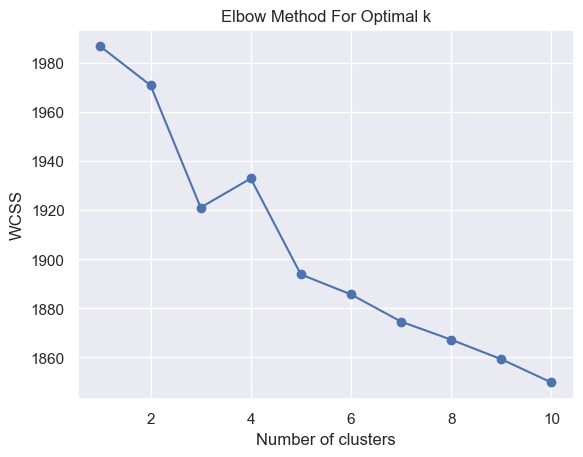

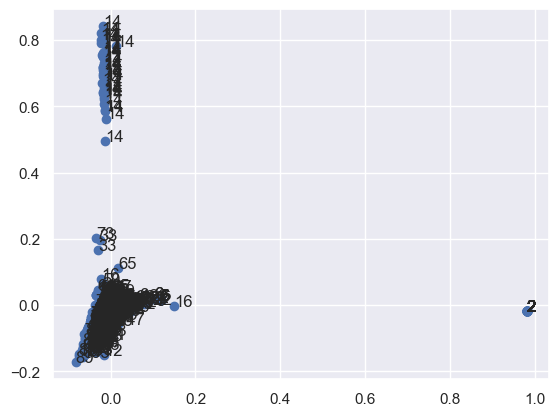

In [27]:
# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(test_df['clean_text'])

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()


# Perform K-means clustering
num_clusters = round(len(test_df['clean_text'])/10)
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)

labels = kmeans.labels_

combined_data = {
    'clean_text': test_df['clean_text'],
    'bias': test_df['bias'],
    'cluster_label': labels,
    'article': test_df['article']
}
result_df = pd.DataFrame(combined_data)


from sklearn.decomposition import PCA

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X.toarray())

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots()
ax.scatter(x_axis, y_axis)

for i, txt in enumerate(labels):
    ax.annotate(txt, (x_axis[i], y_axis[i]))

plt.show()


In [30]:
result_df[result_df['cluster_label'] == 1].groupby('bias').head(5)

,clean_text,bias,cluster_label,article
50,jpmorgan chase ceo jamie dimon told analysts i...,2,1,https://www.foxbusiness.com/markets/jpmorgan-c...
141,jpmorgan chase ceo jamie dimon told analysts i...,2,1,http://www.foxbusiness.com/markets/jpmorgan-ch...
200,seize grey 149th running preakness seizethegre...,2,1,https://radio.foxnews.com/2024/05/19/seize-the...
216,diddy allegedly caught video assaulting exgirl...,2,1,https://radio.foxnews.com/2024/05/18/diddy-sur...
270,wheel fortune fans vented frustration social m...,2,1,https://www.foxnews.com/entertainment/wheel-of...
770,bumpy month april stock market seen ups downs ...,0,1,https://www.cbsnews.com/colorado/news/denver-p...
774,bankrupt cryptocurrency lender genesis repay 2...,0,1,https://www.cbsnews.com/news/genesis-cryptocur...
871,chicago cbs foxtrot market doms kitchen mark...,0,1,https://www.cbsnews.com/chicago/news/foxtrot-d...
1019,tiktok creators sue us government law threaten...,0,1,https://www.cbsnews.com/news/tiktok-60-minute-...
1023,washington pair brothers new york boston take...,0,1,https://www.cbsnews.com/news/brothers-accused-...


In [31]:
result_df['article'][50]

'https://www.foxbusiness.com/markets/jpmorgan-chase-ceo-jamie-dimon-signals-retirement-closer-ever'

In [32]:
result_df['article'][141]

'http://www.foxbusiness.com/markets/jpmorgan-chase-ceo-jamie-dimon-signals-retirement-closer-ever'

## Fake News Detection

In [3]:
fake_news = pd.read_csv("WELFake_Dataset.csv")
fake_news = fake_news.dropna(subset=['title']).reset_index(drop=True)
fake_news.drop(columns=['Unnamed: 0'], inplace=True)
fake_news

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
...,...,...,...
71571,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
71572,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
71573,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
71574,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [4]:
fake_news['clean_text'] = fake_news['text'].apply(lambda x: str(x).lower())
fake_news

,title,text,label,clean_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,no comment is expected from barack obama membe...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"now, most of the demonstrators gathered last ..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,a dozen politically active pastors came here f...
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"the rs-28 sarmat missile, dubbed satan 2, will..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,all we can say on this one is it s about time ...
...,...,...,...,...
71571,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,washington (reuters) - hackers believed to be ...
71572,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"you know, because in fantasyland republicans n..."
71573,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,migrants refuse to leave train at refugee camp...
71574,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,mexico city (reuters) - donald trump’s combati...


In [5]:
for i, row in enumerate(fake_news['clean_text']):
    fake_news.loc[i, 'clean_text'] = ' '.join([word for word in row.split() if word not in en_stopwords])
fake_news

,title,text,label,clean_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,comment expected barack obama members #fyf911 ...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"now, demonstrators gathered last night exercis..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,dozen politically active pastors came private ...
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"rs-28 sarmat missile, dubbed satan 2, replace ..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,say one time someone sued southern poverty law...
...,...,...,...,...
71571,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,washington (reuters) - hackers believed workin...
71572,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"know, fantasyland republicans never questioned..."
71573,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,migrants refuse leave train refugee camp hunga...
71574,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,mexico city (reuters) - donald trump’s combati...


In [6]:
fake_news['clean_text'] = fake_news['clean_text'].str.strip()

fake_news['clean_text'] = fake_news['clean_text'].str.strip().str.replace(r'[^\w\s]', '', regex=True)

fake_news

,title,text,label,clean_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,comment expected barack obama members fyf911 f...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,now demonstrators gathered last night exercisi...
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,dozen politically active pastors came private ...
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,rs28 sarmat missile dubbed satan 2 replace ss1...
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,say one time someone sued southern poverty law...
...,...,...,...,...
71571,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,washington reuters hackers believed working r...
71572,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,know fantasyland republicans never questioned ...
71573,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,migrants refuse leave train refugee camp hunga...
71574,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,mexico city reuters donald trumps combative s...


In [7]:
X_train, X_test, y_train, y_test = train_test_split(fake_news['clean_text'], fake_news['label'], test_size=0.2, stratify=fake_news['label'], random_state=42)
X_test

8584     leave reply click get info formatting 1 leave ...
22229    researching wrapup june 7 presidential primari...
50609    london reuters  north korea continue regularly...
7035     good morning heres need know  trump administra...
3813     last night press swooned bitter mooch speech d...
                               ...                        
31450    thu 20 oct 2016 1328 utc  sky32ddnsnet yahoo u...
12488    radical baltimore mayor ordered baltimore poli...
41814    conservative commentator sonnie johnson slamme...
64782    washington reuters  trump administration offer...
49021    london reuters  british prime minister theresa...
Name: clean_text, Length: 14316, dtype: object

In [8]:
tfidf_fake = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_fake.fit_transform(X_train)
X_test_tfidf = tfidf_fake.transform(X_test)

tfidf_filename = 'ftrained_models/ake_tfidf_vectorizer.joblib'
joblib.dump(tfidf_fake, tfidf_filename)

['fake_tfidf_vectorizer.joblib']

In [9]:
# Model training
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Model evaluation
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9450963956412406
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      7006
           1       0.94      0.95      0.95      7310

    accuracy                           0.95     14316
   macro avg       0.95      0.94      0.95     14316
weighted avg       0.95      0.95      0.95     14316



In [10]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_tfidf, y_train)


model_filename = 'trained_models/rf_fake_news_model.joblib'
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")


y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Model saved to rf_fake_news_model.joblib
Accuracy: 0.9529198100027941
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7006
           1       0.94      0.97      0.95      7310

    accuracy                           0.95     14316
   macro avg       0.95      0.95      0.95     14316
weighted avg       0.95      0.95      0.95     14316



In [11]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_tfidf, y_train)

model_filename = 'rf_fake_news_model.joblib'
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")


y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Model saved to rf_fake_news_model.joblib
Accuracy: 0.9605336686225202
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      7006
           1       0.95      0.98      0.96      7310

    accuracy                           0.96     14316
   macro avg       0.96      0.96      0.96     14316
weighted avg       0.96      0.96      0.96     14316



In [132]:
model = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)